In [1]:
#using dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58635,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.85 GiB
Comm: tcp://127.0.0.1:58668,Total threads: 2
Dashboard: http://127.0.0.1:58669/status,Memory: 7.96 GiB
Nanny: tcp://127.0.0.1:58641,


In [2]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import dask.dataframe as dd
import joblib

df = dd.read_csv('data_treated_orange_seremi.csv')#.compute()

#X=df[['Mp10','Mp10_cal','Mp2_5','Mp2_5_cal','Humedad','Temperatura']]

#y = df['Sector']

X = df[['Mp10','Mp10_cal','Mp2_5','Mp2_5_cal','Humedad','Temperatura']].to_dask_array(lengths=True)
y = df['Sector'].to_dask_array(lengths=True)

from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)#, shuffle=False)

In [4]:
with joblib.parallel_backend('dask'):
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import confusion_matrix


    # A sample toy binary classification dataset
    model = RandomForestClassifier().fit(X_train, y_train)#13
    def confusion_matrix_scorer(clf, X_train, y_train):
            y_pred = clf.predict(X_train)
            cm = confusion_matrix(y_train, y_pred)
            return {'tn': cm[0, 0], 'fp': cm[0, 1],
                    'fn': cm[1, 0], 'tp': cm[1, 1]}
            
    cv_results = cross_validate(model, X_train, y_train, cv=10,
                                scoring=confusion_matrix_scorer)
    # Getting the test set true positive scores
    TP = cv_results['test_tp'].mean()

    # Getting the test set false negative scores
    FN = cv_results['test_fn'].mean()

    # Getting the test set false positive scores
    FP = cv_results['test_fp'].mean()

    # Getting the test set true negative scores
    TN = cv_results['test_tn'].mean()

In [5]:
####TRAINING###
acurracy = (TP+TN) / (TP+TN+FP+FN)
F1_score = 2*TP / ((2*TP) + (FP + FN))
precision = TP / (TP + FP)
specificity = TN / (FP + TN)
sensitivity_recall = TP / (TP + FN)
import math 
MCC = ((TP*TN) - (FP*FN)) / math.sqrt(((TP+FP)*(TP+FN))*((TN+FP)*(TN+FN)))

print("Accuracy: ", acurracy)
print("F1_score: ", F1_score)
print("Precision: ", precision)
print("Specificity: ", specificity)
print("Sensitivity/Recall: ", sensitivity_recall)
print("MCC: ", MCC)

Accuracy:  0.9104062172738797
F1_score:  0.8929570972309111
Precision:  0.9358823935399267
Specificity:  0.9544697118212114
Sensitivity/Recall:  0.853796751038912
MCC:  0.8187423291653481


In [6]:
####TESTING###
from sklearn.metrics import classification_report
pred_test=model.predict(X_test)

conf = confusion_matrix(y_test, pred_test)
TP = conf[1, 1]
FP = conf[0, 1]
TN = conf[0, 0]
FN = conf[1, 0]

acurracy = (TP+TN) / (TP+TN+FP+FN)
F1_score = 2*TP / ((2*TP) + (FP + FN))
precision = TP / (TP + FP)
specificity = TN / (FP + TN)
sensitivity_recall = TP / (TP + FN)
import math 
MCC = ((TP*TN) - (FP*FN)) / math.sqrt(((TP+FP)*(TP+FN))*((TN+FP)*(TN+FN)))

print("Accuracy: ", acurracy)
print("F1_score: ", F1_score)
print("Precision: ", precision)
print("Specificity: ", specificity)
print("Sensitivity/Recall: ", sensitivity_recall)
print("MCC: ", MCC)

Accuracy:  0.9137702014611467
F1_score:  0.8953379013838506
Precision:  0.9356922212861556
Specificity:  0.9555512422360248
Sensitivity/Recall:  0.8583204533745492
MCC:  0.8244663347238534


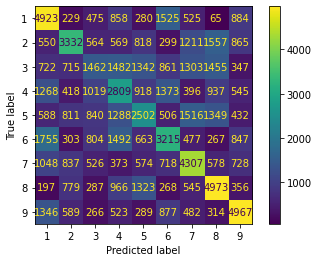

In [7]:
#CM plot_test
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.show()